# Machine Learning with Time Series

In this notebook, we continue with our time series discussion by talking about ML techniques for dealing with time series. Specifically, we focus on supervised learning with time series. Recall in supervised learning that you are given a dataset $D=\{(x_1,y_1),\cdots,(x_n,y_n)\}$ of input-output pairs. Assuming there is some function $y=f(x)$ generating the outputs as functions of inputs, the goal is to use $D$ to learn a function $\hat y=g(x)$ such that $\hat y \approx y$.

Time series are complicated by the fact that both inputs and outputs in the data may depend on time, i.e. $x=x(t)$ and $y=f(x(t),t)$. This makes it difficult to learn $f$ as a function of $x$, since $f$ now depends also on time. In practice, this means that learning $\hat y \approx f(x,t)$ for any value of time is infeasible. This is the problem of extrapolation, which includes trying to predict things that will happen in the future since your model won't have seen them yet. In practice what we often resort to is learning $\hat y$ only for short time spans, and constantly retraining the model periodically to get a new $\hat y$.

The example we'll work through here is _forecasting_, which involves using past points in a time series to predict future points in the time series. Since we have the time series, we can get a supervised learning problem by simply lagging the time series. The lagged values become the inputs, and the original series becomes the outputs. We'll be doing forecasting using the same CO2 dataset from last time. Since that time series is continuous, this means we're doing regression.

The new library we will use in this notebook is [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html), which is an up and coming library useful for extracting features from time series. Note this library is still very much in development, and so you may easily run into bugs and other weird quirks when using it. Nevertheless, the library makes the very time consuming tasks of manipulating time series and extracting features quite easy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from tqdm import tqdm_notebook as tqdm

from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm

from tsfresh import extract_features, select_features, extract_relevant_features
from tsfresh.utilities.dataframe_functions import impute, roll_time_series, make_forecasting_frame

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

np.random.seed(23)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def get_data():
    df = sm.datasets.co2.load_pandas().data
    df.index = pd.to_datetime(df.index)
    df = df.resample('M').mean().interpolate('linear')
    df.columns = ['x']
    return df

def get_scores(model,X_train,y_train,X_test,y_test):
    if model is None:
        yhat = X_train.x
        score = r2_score(y_train,yhat)
        print('Training R-squared: %f' % round(score,3))
        yhat = X_test.x
        score = r2_score(y_test,yhat)
        print('Test R-squared: %f' % round(score,3))
    else:
        yhat = model.predict(X_train)
        score = r2_score(y_train,yhat)
        print('Training R-squared: %f' % round(score,3))
        yhat = model.predict(X_test)
        score = r2_score(y_test,yhat)
        print('Test R-squared: %f' % round(score,3))
        if isinstance(model,RandomForestRegressor):
            score = model.oob_score_
            print('Out of Bag Score: %f' % round(score,3))

def time_series_split(X,y,test_size=0.2):
    split_index = round(len(y)*(1-test_size))-1
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    return X_train, X_test, y_train, y_test

def get_lag_features(X,features=None,n_lags=1):
    if features is None:
        features = X.columns
    for feature in features:
        for i in range(1,n_lags+1):
            X[feature+'_lag_'+str(i)] = X[feature].shift(i).fillna(method='bfill')
        X[feature+'_lag_0'] = X[feature].copy()
        X = X.drop(feature,axis=1)
    return X

def plot_forecast(y,yhat):
    yhat = pd.Series(data=yhat,index=y.index)
    plt.figure(figsize=(15, 6))
    plt.plot(y, label="y")
    plt.plot(yhat, label="yhat")
    plt.legend()
    plt.show()

## Simple Forecasting

We begin by doing a simple type of forecasting, using the oldest values in our dataset to predict the newest values in our dataset. It is important when dealing with time series that we train on past values, but only predict on future values. Failing to adhere to this leads to _data leakage_, which means using information in real life we wouldn't have to make predictions. In time series, data leakage means using future values to predict past values, which is not allowed. This means that we have to do cross validation differently for time series than for regular IID data. We cannot randomly shuffle the dataset or we risk data leakage. 

Thus, we always take the test set to be the most recent values, and the training set to be the older values. You still want most of your data going into the training set though. In our case, we'll take the last 20% of values to go in the test set, and the first 80% to go in the training set. That is, we're using the first 80% of our data to forecast the remaining 20% of our data.

We start by loading the time series into a dataframe. We create the target values by shifting the time series ahead by one. This gives two columns, the input series `df.x`, and the output series `df.y`. Observe that the output series is indeed a shift ahead in time of the input series. We also fill in the first value of the output series because otherwise it would return NaN (why?).

In [3]:
df = get_data()

In [5]:
df['y'] = df.x.shift(-1).fillna(method='ffill')
df = df[['x','y']]
df.head()

,x,y
1958-03-31,316.100000,317.200000
1958-04-30,317.200000,317.433333
1958-05-31,317.433333,316.529167
1958-06-30,316.529167,315.625000
1958-07-31,315.625000,314.950000


The first naive thing you might try at this point is to just use a regression model to predict $y$, given $x$. Unfortunately with time series this is a bad idea. For one thing, ML models work best when the data is as close to IID as possible (meaning they should be made stationary). For another, such a simple model isn't able to capture the time dependence in the input features, which means we're not squeezing all the information out of the time series to make a forecast.

We can see the failure of this attempt below. We first do time series cross validation, as described above, and then train a random forest regressor on the data. Observe that we easily overfit the training set (R-squared is almost 1.0), but the test score is horrendously bad (R-squared is negative). We can make a plot of the forecast against the true time series to see what is happening here. Observe that the forecast is flattening out, which means it's not able to capture the increasing trend and seasonal behaviors.

Also, observe the out of bag score. The OOB score is a special score you can get from random forest models. Without going into specifics, it gives you a simple way to estimate what your test score would be if you had shuffled the data instead and did regular cross validation. Doing this results in data leakage, as I mentioned, so you shouldn't be surprised if the OOB score is a bit higher than the test score with time series. In this case, the OOB is way too high. Thus, if you just treated your time series as IID and did naive shuffling, your test score would look like OOB, and fool you into thinking you're doing well when you're really not. Moral: avoid data leakage!

Training R-squared: 0.998000
Test R-squared: -1.156000
Out of Bag Score: 0.987000


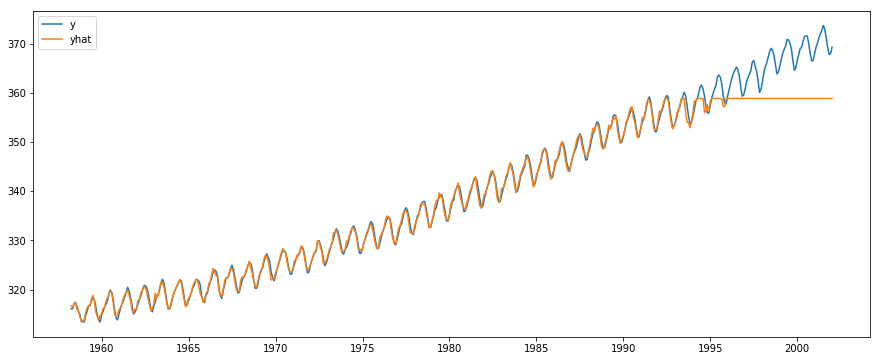

In [112]:
X = df[['x']]
y = df['y']
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y,yhat)

We can try to remedy the problem of non-stationarity by making the time series stationary. Note that since both `X` and `y` are time series (one is a lagged copy of the other), we have to make both of them stationary, not just `X`. Recall that we can approximate a stationary time series using simple differencing, which we'll use below to get roughly stationary time series.

We now use these new, sort of stationary time series `X_diff` and `y_diff` to train the same model as above. Notice now the model doesn't overfit as much, and the test score is actually positive now, and even better than the OOB score. It's still not great though. How can we improve it?

In [6]:
X_diff = df[['x']].diff().fillna(method='bfill')
y_diff = df['y'].diff().fillna(method='bfill')

Training R-squared: 0.823000
Test R-squared: 0.502000
Out of Bag Score: 0.338000


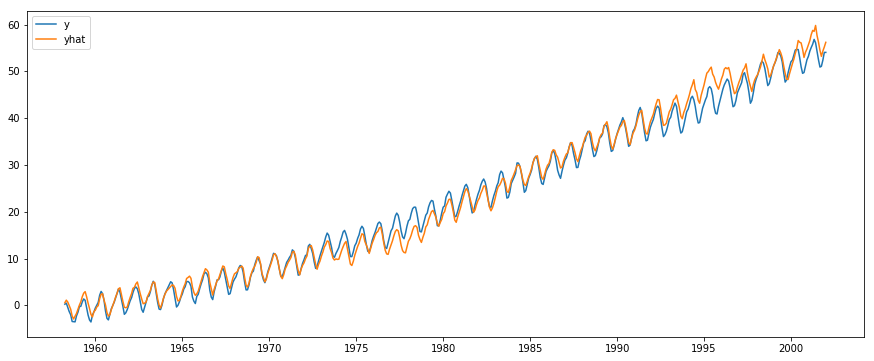

In [7]:
X = X_diff.copy()
y = y_diff
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y.cumsum(),yhat.cumsum())

While we've made the time series stationary, we still haven't explicitely captured the time dependence of the series in our features. We can capture this dependence by using lag features, which are features created by taking lagged copies of the time series. Recall we can estimate how much lag dependence there is in a time series by looking at an autocorrelation plot.

Below we look at an autocorrelation plot of `X_diff` up to 100 lags. We can see that the only significant lag dependences are the periods (due to the seasonality). We could take care of this problem if we wanted by taking another difference `X_diff.diff(periods=12)` to get rid of the periodic dependence. I avoid doing this though because I'm lazy, as it makes reconstructing the time series for the forecasting plots more annoying (forgive me).

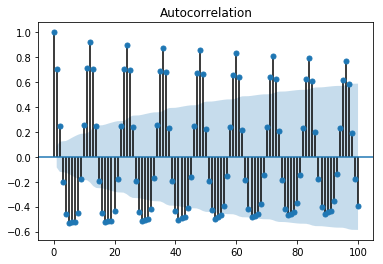

In [89]:
plot_acf(X_diff.x,lags=100)
plt.show()

We can hopefully capture most of the lag-dependence by keeping only the top few lags as features. Below we keep the top 20 lags as features. This gives a new dataframe `X` having 21 features, 1 feature for the original time series plus 20 lag features. Doing the same thing above with this new `X`, we see a substantial improvement in our results. Our training score, test score, and OOB score are all hovering above 0.96. Moreover, the forecast plot shows that we've captured the time series pretty well, though it does get worse with time (this is always true, and it's why you have to constantly retrain models using time series data when you get new data).

Note: We can try to improve our model even more by adding in time features as well. This can include separate features for things like time of day, day of year, day of month, day of week, hour of day, etc. Adding such features often can help deal with seasonal behavior, provided your seasons have periods matching the time feature you're adding in.

Training R-squared: 0.987000
Test R-squared: 0.934000
Out of Bag Score: 0.912000


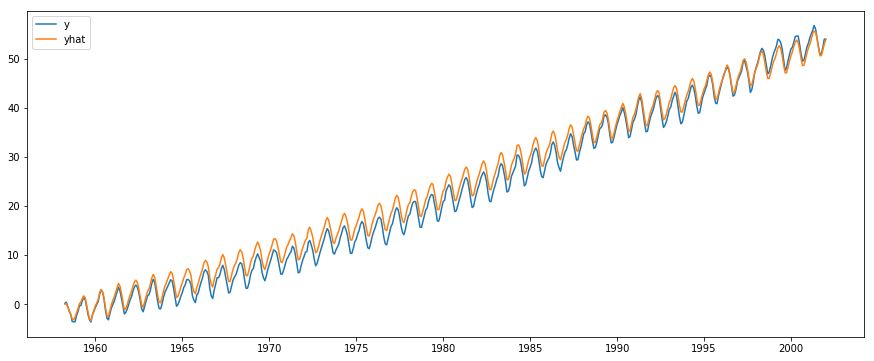

In [8]:
X = get_lag_features(X_diff.copy(),'x',20)
y = y_diff
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

model = RandomForestRegressor(n_estimators=50,min_samples_leaf=1,max_features=0.2,oob_score=True,n_jobs=-1)
model.fit(X_train,y_train)

get_scores(model,X_train,y_train,X_test,y_test)
yhat = model.predict(X)
plot_forecast(y.cumsum(),yhat.cumsum())

Though our above forecast may look really good, looks can be deceiving. A better question to ask is this: How much better is our forecast from a naive forecast that doesn't require any ML at all? Such a simple "model" is called a baseline or persistence model, and gives you a good idea how much you can improve your results by using ML. Below we take our persistence model to be a simple forecast of $\hat y = x$. That is, we forecast a value just by using its lagged value with no learning at all. 

Observe that a persistence model alone gives a test score of 0.93. Such a high score on such a simple model means you should seriously question whether doing ML on this time series is worth the effort at all. Why put in the time to build a fancy model when such a simple baseline will work really well? This is why it's always a good idea to build a very simple baseline model first, so you can see what you're up against and decide whether the effort of ML is really worth it. Sometimes it is and sometimes it's not.

Training R-squared: 0.992000
Test R-squared: 0.933000


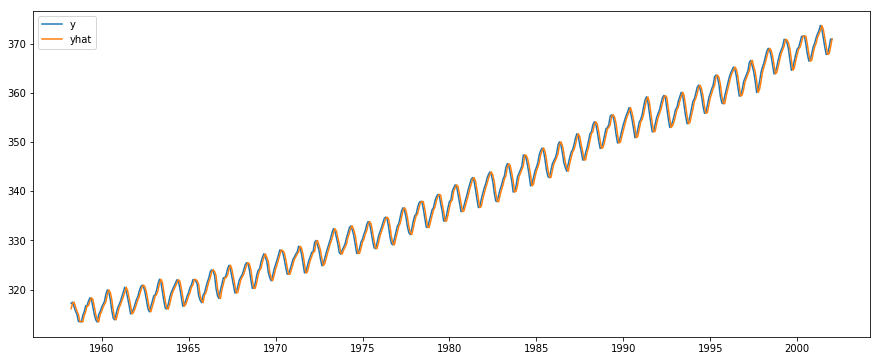

In [9]:
X = df[['x']]
y = df['y']
X_train, X_test, y_train, y_test = time_series_split(X,y,test_size=0.2)

get_scores(None,X_train,y_train,X_test,y_test)
yhat = X.x
plot_forecast(y,yhat)

## Streaming Prediction

We now briefly talk about a common use case of time series data, namely to do streaming prediction. In ML this is called [online learning](https://en.wikipedia.org/wiki/Online_machine_learning). In online learning, you want to train your model continuously and make predictions in real time. This allows you to more easily adapt to fluid changes in your data over time. The tradeoff is that online learning isn't as easy as regular supervised learning, and a lot of the usual models don't work well for it. One such model that does is [AdaBoost](https://en.wikipedia.org/wiki/AdaBoost), which is comparable in quality to random forests and boost trees, but works well in online settings.

To do streaming prediction with time series we first need to reformat the data in a way that makes streaming appropriate. To do this we use the fairly new `tsfresh` library. What it will do is take our time series and create a bunch of mini time series out of it. Each mini time series is our original time series up to some point in time, for each point in time we have data for. We use each such mini time series $x_1,\cdots,x_{t-1}$ to predict the next point $x_t$ in the series. Tsfresh makes it easy to get these mini time series with its `make_forecasting_frame` function. 

Below we create these minitime series by using a window size of 20, and by moving the series ahead by 1 point at each step. This means that at each step we will only use the last 20 values to predict the current value, and we only step by 1 new point at a time. I specified 20 because it's roughly equivalent to taking 20 lags like I did above.

In [10]:
warnings.filterwarnings('ignore')
x,y = make_forecasting_frame(df.x, kind="co2", max_timeshift=20, rolling_direction=1)
x.head()

,time,value,id,kind
9785,1958-03-31,316.1,1958-04-30,co2
9261,1958-03-31,316.1,1958-05-31,co2
9786,1958-04-30,317.2,1958-05-31,co2
8738,1958-03-31,316.1,1958-06-30,co2
9262,1958-04-30,317.2,1958-06-30,co2


The other thing that tsfresh is great for is extracting important features from time series. There are a number of features embedded in a time series that may help make useful predictions. These include things like the number of oscillations, the amplitudes, the frequencies, the mean and standard deviation of the series, lag values, and many other features. With tsfresh we can automatically extract tons of useful features with the `extract_features` function. I won't go into detail on how this works, see [here](https://tsfresh.readthedocs.io/en/latest/text/list_of_features.html) for details, but just know that we're using it to extract information from our series that may be useful for making predictions.

In [12]:
warnings.filterwarnings('ignore')
X = extract_features(x, column_id="id", column_sort="time", column_value="value", impute_function=impute, 
                    show_warnings=False, disable_progressbar=True)
X = X.loc[:,X.apply(pd.Series.nunique) != 1]

We now use these extracted features from our set of mini time series to do online learning using sklearn's AdaBoost implementation. Observe that with online learning we train the model with one new data point at a time and make predictions one data point at a time. Below we plot the streaming forecast values we predicted. What do you think of it?

In [13]:
model = AdaBoostRegressor()

yhat = np.zeros(len(y))
yhat[0] = y.iloc[0]

for i in tqdm(range(1,len(y))):
    X_prevs = X.iloc[:i]
    y_prevs = y[:i]
    Xi = X.iloc[i,:].values.reshape(1,-1)
    model.fit(X_prevs,y_prevs)
    yhat[i] = model.predict(Xi)
    
yhat = pd.Series(data=yhat,index=y.index)

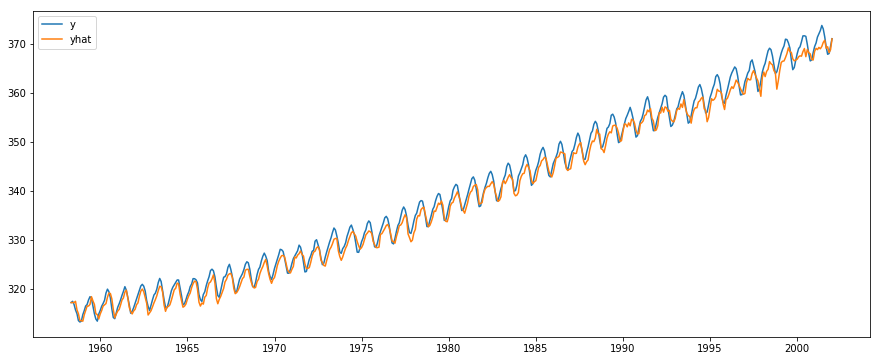

In [54]:
plt.figure(figsize=(15, 6))
plt.plot(y, label="y")
plt.plot(yhat, label="yhat")
plt.legend()
plt.show()